In this project you will: 

Use U-Net architecture for segmentation

Create train function and evaluator for training loop

# Task 1: setup colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

     |████████████████████████████████| 88 kB 838 kB/s 
     |████████████████████████████████| 58 kB 4.3 MB/s 
     |████████████████████████████████| 376 kB 8.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=92510131a587f45ac6f700b53bf0a4a6997d6bcdc28c1355f6f2dc695bf015e0
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=e05bf03b967c9ecb14936a7e92aa983fadf1b11bc30edac3283ad80c2dea00f2
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-2_tbn5fd
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-2_tbn5fd
    

## Download dataset
original author of the dataset: https://github.com/VikramShenoy97/Human-Segmentation-Dataset

In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 21.46 MiB/s, done.
Resolving deltas: 100% (3/3), done.


some common imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
!pip install opencv-python-headless==4.5.2.52

     |████████████████████████████████| 38.2 MB 23.3 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalled opencv-python-headless-4.5.5.64


In [5]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

## Task 2: Setup configurations

In [6]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0' # there are many encoders can choose, e.g. resnet16 etc.
WEIGHTS = 'imagenet'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

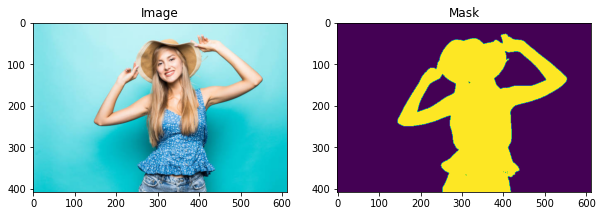

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('Image')
ax1.imshow(image)
ax2.set_title('Mask')
ax2.imshow(mask)

In [10]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

## Task 3: Augmentation functions

alubmentation documentation: https://albumentations.ai/docs/

In [13]:
import albumentations as A


In [14]:
def get_train_augs():
  return A.Compose([
                    A.Resize(IMG_SIZE, IMG_SIZE),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
                    A.Resize(IMG_SIZE,IMG_SIZE)
  ])

## Task 4: Create custom dataset

In [15]:
from torch.utils.data import Dataset

In [16]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h,w,c)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    # (h,w,c) -> (c,h,w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask



In [17]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [19]:
print(f"size of trainset: {len(trainset)}")
print(f"size of validset: {len(validset)}")

size of trainset: 232
size of validset: 58


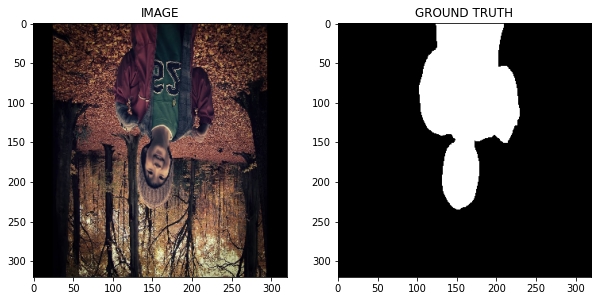

In [21]:
idx = 21
image, mask = trainset[idx]
helper.show_image(image,mask)

## Task 5: load dataset into batches

In [22]:
from torch.utils.data import DataLoader

In [25]:
trainloader = DataLoader(trainset,batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [26]:
print(f"total number of batches in trainloader: {len(trainloader)}")
print(f"total number of batches in validloader: {len(validloader)}")

total number of batches in trainloader: 15
total number of batches in validloader: 4


In [27]:
for image, mask in trainloader:
  break

print(f"one batch image shape: {image.shape}")
print(f"one batch mask shape: {mask.shape}")

one batch image shape: torch.Size([16, 3, 320, 320])
one batch mask shape: torch.Size([16, 1, 320, 320])


## Task 6: create segmentation model
segmentation_models_pytorch documentation: https://smp.readthedocs.io/en/latest/

In [28]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [29]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2

    return logits

  

In [30]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

## Task 7: create train and validation function

In [31]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)

def valid_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss/len(data_loader)





## Task 8: Train the model

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [33]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = valid_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("MODEL SAVED.")
    best_valid_loss = valid_loss

  print(f"Epoch: {i+1}, Train_loss: {train_loss}, Valid_loss: {valid_loss}")


100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


MODEL SAVED.
Epoch: 1, Train_loss: 0.7791560928026835, Valid_loss: 0.610506534576416


100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


MODEL SAVED.
Epoch: 2, Train_loss: 0.40494415163993835, Valid_loss: 0.3569547086954117


100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Epoch: 3, Train_loss: 0.3015092710653941, Valid_loss: 0.4048314690589905


100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Epoch: 4, Train_loss: 0.2760484973589579, Valid_loss: 0.4736524075269699


100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


MODEL SAVED.
Epoch: 5, Train_loss: 0.3446428656578064, Valid_loss: 0.29710904881358147


100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


MODEL SAVED.
Epoch: 6, Train_loss: 0.24181884229183198, Valid_loss: 0.2457185871899128


100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Epoch: 7, Train_loss: 0.21048410733540854, Valid_loss: 0.27571479231119156


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


MODEL SAVED.
Epoch: 8, Train_loss: 0.18227801124254864, Valid_loss: 0.23393525183200836


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


MODEL SAVED.
Epoch: 9, Train_loss: 0.16184904177983603, Valid_loss: 0.20142636448144913


100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


MODEL SAVED.
Epoch: 10, Train_loss: 0.17536079734563828, Valid_loss: 0.18925600871443748


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch: 11, Train_loss: 0.17424237231413522, Valid_loss: 0.20012405142188072


100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


MODEL SAVED.
Epoch: 12, Train_loss: 0.16497695793708164, Valid_loss: 0.17798755690455437


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


MODEL SAVED.
Epoch: 13, Train_loss: 0.13054944723844528, Valid_loss: 0.17286067456007004


100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Epoch: 14, Train_loss: 0.13819533040126164, Valid_loss: 0.21629638969898224


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epoch: 15, Train_loss: 0.1472189913193385, Valid_loss: 0.2041332945227623


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epoch: 16, Train_loss: 0.11738258053859076, Valid_loss: 0.2127716988325119


100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Epoch: 17, Train_loss: 0.12599347432454427, Valid_loss: 0.2254403419792652


100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Epoch: 18, Train_loss: 0.11948202004035315, Valid_loss: 0.2895693928003311


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epoch: 19, Train_loss: 0.11238539864619573, Valid_loss: 0.27075643464922905


100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


MODEL SAVED.
Epoch: 20, Train_loss: 0.14082453697919844, Valid_loss: 0.17236789129674435


100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Epoch: 21, Train_loss: 0.12207606782515844, Valid_loss: 0.1776331514120102


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epoch: 22, Train_loss: 0.14730717440446217, Valid_loss: 0.22326689213514328


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Epoch: 23, Train_loss: 0.17293821225563685, Valid_loss: 0.1937391348183155


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Epoch: 24, Train_loss: 0.13946499029795328, Valid_loss: 0.2197590209543705


100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

Epoch: 25, Train_loss: 0.12433400849501292, Valid_loss: 0.22118960693478584


## Task 9: inference

In [36]:
idx = 22

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c, h, w) -> (1, c, h, w)

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0


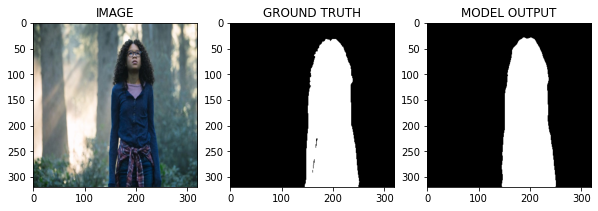

In [37]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))